# Encoding a midi file into note-wise and chord-wise text file
***

In [2]:
import argparse
import random
import os
import numpy as np
from math import floor
from pyknon.genmidi import Midi
from pyknon.music import NoteSeq, Note
import music21
from pathlib import Path

## 1a: Store midi file as a music21 midifile object
***

In [3]:
fname = "midi-files/sonat-1.mid"

mf=music21.midi.MidiFile()
mf.open(fname)
mf.read()
mf.close()
mf

<MidiFile 3 tracks
  <MidiTrack 0 -- 20 events
    <MidiEvent DeltaTime, t=0, track=0, channel=None>
    <MidiEvent SEQUENCE_TRACK_NAME, t=None, track=0, channel=None, data=b'Sonatina IV  Andante'>
    <MidiEvent DeltaTime, t=0, track=0, channel=None>
    <MidiEvent TEXT_EVENT, t=None, track=0, channel=None, data=b'By W. A. Mozart'>
    <MidiEvent DeltaTime, t=0, track=0, channel=None>
    <MidiEvent COPYRIGHT_NOTICE, t=None, track=0, channel=None, data=b'Copyright \xa9 <Year> by <Name>'>
    <MidiEvent DeltaTime, t=0, track=0, channel=None>
    <MidiEvent COPYRIGHT_NOTICE, t=None, track=0, channel=None, data=b'All Rights Reserved'>
    <MidiEvent DeltaTime, t=0, track=0, channel=None>
    <MidiEvent TEXT_EVENT, t=None, track=0, channel=None, data=b'Generated by NoteWorthy Composer'>
    <MidiEvent DeltaTime, t=0, track=0, channel=None>
    <MidiEvent SET_TEMPO, t=None, track=0, channel=None, data=b'\n,*'>
    <MidiEvent DeltaTime, t=0, track=0, channel=None>
    <MidiEvent KEY_SIGNATU

## 1b: Convert midifile object into stream object
***

In [4]:
midi_stream=music21.midi.translate.midiFileToStream(mf)
midi_stream

<music21.stream.Score 0x1165aa518>

Here we explore 3 ways in which stream object can be represented:
1. Graphical score
2. Audio player
3. Text

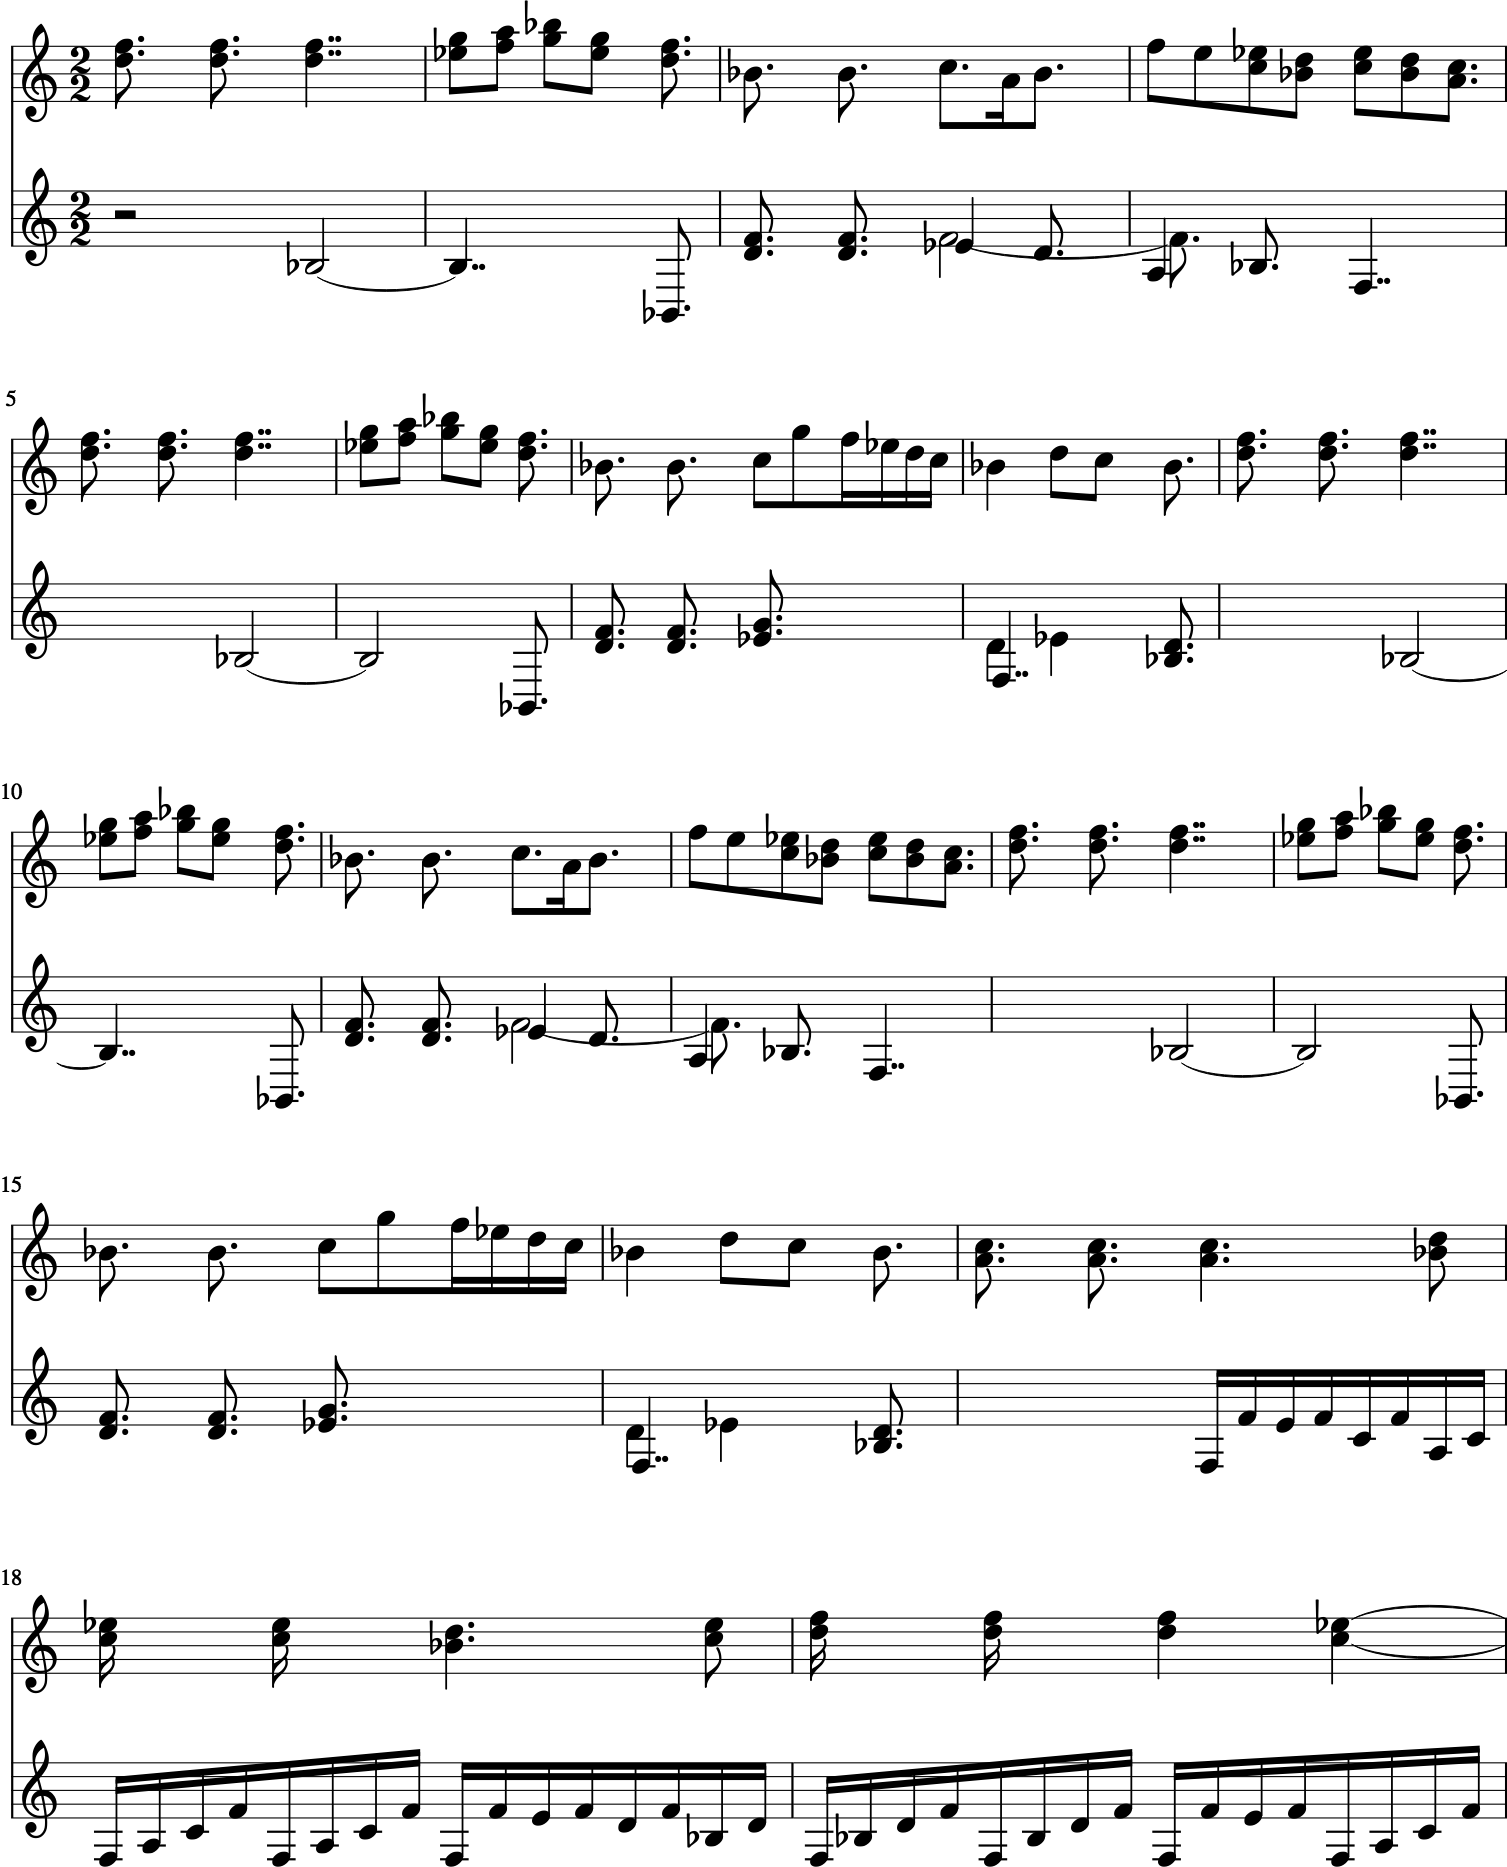

In [5]:
midi_stream.show()

In [6]:
midi_stream.show('midi')

In [7]:
midi_stream.show('text')

{0.0} <music21.stream.Part 0x1165c06d8>
    {0.0} <music21.instrument.Piano Piano>
    {0.0} <music21.tempo.MetronomeMark maestoso Quarter=90.0>
    {0.0} <music21.key.Key of B- major>
    {0.0} <music21.meter.TimeSignature 2/2>
    {0.0} <music21.stream.Voice 0x1165c05f8>
        {0.0} <music21.chord.Chord D5 F5>
        {1.0} <music21.chord.Chord D5 F5>
        {2.0} <music21.chord.Chord D5 F5>
        {4.0} <music21.chord.Chord E-5 G5>
        {4.5} <music21.chord.Chord F5 A5>
        {5.0} <music21.chord.Chord G5 B-5>
        {5.5} <music21.chord.Chord E-5 G5>
        {6.0} <music21.chord.Chord D5 F5>
        {8.0} <music21.note.Note B->
        {9.0} <music21.note.Note B->
        {10.0} <music21.note.Note C>
        {10.75} <music21.note.Note A>
        {11.0} <music21.note.Note B->
        {12.0} <music21.note.Note F>
        {12.5} <music21.note.Note E>
        {13.0} <music21.chord.Chord C5 E-5>
        {13.5} <music21.chord.Chord B-4 D5>
        {14.0} <music21.chord.Chord C5

## 1c: Define the parameters of encoding
***

In [8]:
sample_freq=4
note_range=38
note_offset=45
chamber=0
numInstruments=1

## 1d: Set your midi stream object as s

And you can explore the midi stream object
***

In [9]:
s = midi_stream
print(s.duration.quarterLength)

198.75


In [10]:
dir(s)

['_DOC_ATTR',
 '_DOC_ORDER',
 '__add__',
 '__bool__',
 '__class__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_accumulatedSeconds',
 '_activeSite',
 '_activeSiteStoredOffset',
 '_atSoundingPitch',
 '_cache',
 '_classListFullyQualifiedCacheDict',
 '_classSetCacheDict',
 '_classTupleCacheDict',
 '_consolidateLayering',
 '_deepcopySubclassable',
 '_derivation',
 '_durSpanOverlap',
 '_duration',
 '_editorial',
 '_elements',
 '_endElements',
 '_findLayering',
 '_fixMeasureNumbers',
 '_getActiveSite',
 '_getAtSoundingPitch',
 '_getClef',
 '_getDerivation',
 '_

In [11]:
s[0].elements

(<music21.instrument.Piano Piano>,
 <music21.tempo.MetronomeMark maestoso Quarter=90.0>,
 <music21.key.Key of B- major>,
 <music21.meter.TimeSignature 2/2>,
 <music21.stream.Voice 0x1165c05f8>,
 <music21.stream.Voice 0x1165c0630>,
 <music21.tempo.MetronomeMark maestoso Quarter=90.0>)

## Step 2: Encode stream into chordwise text

Using the following function:  

**stream_to_chordwise(s, chamber, note_range, note_offset, sample_freq)**
***

## 2a. Create empty array (3D-tensor) to store encoding

In [12]:
maxTimeStep = floor(s.duration.quarterLength * sample_freq)+1
score_arr = np.zeros((maxTimeStep, numInstruments, note_range))

print(maxTimeStep, "\n", score_arr.shape)

796 
 (796, 1, 38)


## 2b. Define 2 types of filters (Note and Chord) to extract data from stream object
***

In [13]:
# define two types of filters because notes and chords have different structures for storing their data
# chord have an extra layer because it consist of multiple notes

noteFilter=music21.stream.filters.ClassFilter('Note')
chordFilter=music21.stream.filters.ClassFilter('Chord')

## 2c. Recurse through the stream object using Note filter to get a list of notes
***

In [14]:
for n in s.recurse().addFilter(noteFilter):
    print(n)

<music21.note.Note B->
<music21.note.Note B->
<music21.note.Note C>
<music21.note.Note A>
<music21.note.Note B->
<music21.note.Note F>
<music21.note.Note E>
<music21.note.Note B->
<music21.note.Note B->
<music21.note.Note C>
<music21.note.Note G>
<music21.note.Note F>
<music21.note.Note E->
<music21.note.Note D>
<music21.note.Note C>
<music21.note.Note B->
<music21.note.Note D>
<music21.note.Note C>
<music21.note.Note B->
<music21.note.Note B->
<music21.note.Note B->
<music21.note.Note C>
<music21.note.Note A>
<music21.note.Note B->
<music21.note.Note F>
<music21.note.Note E>
<music21.note.Note B->
<music21.note.Note B->
<music21.note.Note C>
<music21.note.Note G>
<music21.note.Note F>
<music21.note.Note E->
<music21.note.Note D>
<music21.note.Note C>
<music21.note.Note B->
<music21.note.Note D>
<music21.note.Note C>
<music21.note.Note B->
<music21.note.Note B->
<music21.note.Note B->
<music21.note.Note C>
<music21.note.Note A>
<music21.note.Note B->
<music21.note.Note F>
<music21.note

In [15]:
# pitch.midi-note_offset: pitch is the numerical representation of a note. 
#                         note_offset is the the pitch relative to a zero mark. eg. B-=25, C=27, A=24

# n.offset: the timestamps of each note, relative to the start of the score
#           by multiplying with the sample_freq, you make all the timestamps integers

# n.duration.quarterLength: the duration of that note as a float eg. quarter note = 0.25, half note = 0.5
#                           multiply by sample_freq to represent duration in terms of timesteps
notes=[]
instrumentID=0

for n in s.recurse().addFilter(noteFilter):
    if chamber:
        # assign_instrument where 0 means piano-like and 1 means violin-like, and -1 means neither
        instrumentID=assign_instrument(n.activeSite.getInstrument())
        if instrumentID==-1:
            print("error. unknown instrument")
    notes.append((n.pitch.midi-note_offset, floor(n.offset*sample_freq), 
                  floor(n.duration.quarterLength*sample_freq), instrumentID))

In [16]:
print(len(notes))
notes[-5:]

363


[(20, 424, 11, 0),
 (17, 496, 4, 0),
 (18, 500, 4, 0),
 (20, 680, 11, 0),
 (17, 752, 4, 0)]

## 2d. Recurse through the stream object using Chord filter and add to the list of notes
***

In [17]:
# do the same using a chord filter

for c in s.recurse().addFilter(chordFilter):
    # unlike the noteFilter, this line of code is necessary as there are multiple notes in each chord
    # pitchesInChord is a list of notes at each chord eg. (<music21.pitch.Pitch D5>, <music21.pitch.Pitch F5>)
    pitchesInChord=c.pitches
    
    if chamber:
        instrumentID=assign_instrument(n.activeSite.getInstrument())     
        if instrumentID==-1:
            break # return []

    # do same as noteFilter and append all notes to the notes list
    for p in pitchesInChord:
        notes.append((p.midi-note_offset, floor(c.offset*sample_freq), 
                      floor(c.duration.quarterLength*sample_freq), instrumentID))

In [18]:
print(len(notes))
notes[-5:]

705


[(20, 736, 3, 0),
 (17, 740, 3, 0),
 (23, 740, 3, 0),
 (18, 744, 3, 0),
 (22, 744, 3, 0)]

## 2e. Using the list of notes, populate the array

score_array is structured by timesteps (rows) and notes (columns)
***

In [19]:
# the variable/list "notes" is a collection of all the notes in the song, not ordered in any significant way

for n in notes:
    
    # pitch is the first variable in n, previously obtained by n.midi-note_offset
    pitch=n[0]
    
    # do some calibration for notes that fall our of note range
    # i.e. less than 0 or more than note_range
    while pitch<0:
        pitch+=12
    while pitch>=note_range:
        pitch-=12
        
    # 3rd element refers to instrument type => if instrument is violin, use different pitch calibration
    if n[3]==1:      #Violin lowest note is v22
        while pitch<22:
            pitch+=12

    # start building the 3D-tensor of shape: (796, 1, 38)
    # score_arr[0] = timestep
    # score_arr[1] = type of instrument
    # score_arr[2] = pitch/note out of the range of note eg. 38
    
    # n[0] = pitch
    # n[1] = timestep
    # n[2] = duration
    # n[3] = instrument
    
    score_arr[n[1], n[3], pitch]=1                  # Strike note
    score_arr[n[1]+1:n[1]+n[2], n[3], pitch]=2      # Continue holding note

In [20]:
print(score_arr.shape)
# print first 5 timesteps
score_arr[:5,0,]

(796, 1, 38)


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
        2., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0.,
        2., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        1., 0., 0., 0., 0., 0.]])

## 2f. Convert each timestep from a list into a string
***

In [21]:
instr={}
instr[0]="p"
instr[1]="v"

score_string_arr=[]

# loop through all timesteps
for timestep in score_arr:
    
    # selecting the instruments: i=0 means piano and i=1 means violin
    for i in list(reversed(range(len(timestep)))):   # List violin note first, then piano note
        
        #
        score_string_arr.append(instr[i]+''.join([str(int(note)) for note in timestep[i]]))      

In [22]:
print(type(score_string_arr), len(score_string_arr))
score_string_arr[:5]

<class 'list'> 796


['p00000000000000000000000000000100100000',
 'p00000000000000000000000000000200200000',
 'p00000000000000000000000000000200200000',
 'p00000000000000000000000000000000000000',
 'p00000000000000000000000000000100100000']

### Output of stream_to_chordwise() 
is a list of strings where each element is the notes that will be played or held on at each timestep
<br/><br/><br/>

## Step 3: Add modulations (not sure for what)

Using the function:  
**add_modulations(score_string_arr)**
***

In [23]:
modulated=[]
# get the note range from the array
note_range=len(score_string_arr[0])-1

for i in range(0,12):
    for chord in score_string_arr:
        
        # minus the instrument letter eg. 'p'
        # add 6 zeros on each side of the string
        padded='000000'+chord[1:]+'000000'
        
        # add back the instrument letter eg. 'p'
        # append window of len=note_range back into 
        # eg. if we have "00012345000"
        # iteratively, we want to get "p00012", "p00123", "p01234", "p12345", "p23450", "p34500", "p45000",
        modulated.append(chord[0]+padded[i:i+note_range])

**Example for i = 0**  
Step1: p00000000000000000000000000000100100000  
Step2: 00000000000000000000000000000000000100100000000000  
Step3: ['p00000000000000000000000000000000000100']

In [24]:
# 796 * 12
print(len(modulated))
modulated[:5]

9552


['p00000000000000000000000000000000000100',
 'p00000000000000000000000000000000000200',
 'p00000000000000000000000000000000000200',
 'p00000000000000000000000000000000000000',
 'p00000000000000000000000000000000000100']

## Step 4: Create notewise encoding from chordwise encoding

Using the function:  
**chord_to_notewise(long_string, sample_freq)**
***

## 4a. Create a list of notewise events
***

In [25]:
# input of this function is a modulated string
long_string = modulated

translated_list=[]

# for every timestep of the string
for j in range(len(long_string)):
    
    # chord at timestep j eg. 'p00000000000000000000000000000000000100'
    chord=long_string[j]
    next_chord=""
    
    # range is from next_timestep to max_timestep
    for k in range(j+1, len(long_string)):
        
        # checking if instrument of next chord is same as current chord
        if long_string[k][0]==chord[0]:
            
            # if same, set next chord as next element in modulation
            # otherwise, keep going until you find a chord with the same instrument
            # when you do, set it as the next chord
            next_chord=long_string[k]
            break
    
    # set prefix as the instrument
    # set chord and next_chord to be without the instrument prefix
    # next_chord is necessary to check when notes end
    prefix=chord[0]
    chord=chord[1:]
    next_chord=next_chord[1:]
    
    # checking for non-zero notes at one particular timestep
    # i is an integer indicating the index of each note the chord
    for i in range(len(chord)):
        
        if chord[i]=="0":
            continue
        
        # set note as 2 elements: instrument and index of note
        # examples: p22, p16, p4
        note=prefix+str(i)                
        
        # if note in chord is 1, then append the note eg. p22 to the list
        if chord[i]=="1":
            translated_list.append(note)
        
        # If chord[i]=="2" do nothing - we're continuing to hold the note
        
        # unless next_chord[i] is back to "0" and it's time to end the note.
        if next_chord=="" or next_chord[i]=="0":      
            translated_list.append("end"+note)

    # wait indicates end of every timestep
    if prefix=="p":
        translated_list.append("wait")

In [26]:
print(len(translated_list))
translated_list[:10]

25812


['p35',
 'wait',
 'wait',
 'endp35',
 'wait',
 'wait',
 'p35',
 'wait',
 'wait',
 'endp35']

## 4b. Convert list into string and stack "waits"
***

In [27]:
# this section transforms the list of notes into a string of notes

# initialize i as zero and empty string
i=0
translated_string=""


while i<len(translated_list):
    
    # stack all the repeated waits together using an integer to indicate the no. of waits
    # eg. "wait wait" => "wait2"
    wait_count=1
    if translated_list[i]=='wait':
        while wait_count<=sample_freq*2 and i+wait_count<len(translated_list) and translated_list[i+wait_count]=='wait':
            wait_count+=1
        translated_list[i]='wait'+str(wait_count)
        
    # add next note
    translated_string+=translated_list[i]+" "
    i+=wait_count

In [28]:
translated_string[:100]

'p35 wait2 endp35 wait2 p35 wait2 endp35 wait2 p19 p35 wait6 endp35 wait2 p36 wait1 endp36 wait5 endp'

In [29]:
len(translated_string)

126877

## Step 5. Export Notewise and Chordwise encodings into .txt files
***

## 5a. Check variables containing Notewise and Chordwise encodings
***

In [30]:
print("chordwise encoding type and length:", type(modulated), len(modulated))
print("notewise encoding type and length:", type(translated_string), len(translated_string))


chordwise encoding type and length: <class 'list'> 9552
notewise encoding type and length: <class 'str'> 126877


## 5b. Turn encodings into strings and export into respective folders
***

In [31]:
chordwise_folder = "./txt-files/chordwise/"
notewise_folder = "./txt-files/notewise/"

# export chordwise encoding
f=open(chordwise_folder+fname[11:-4]+".txt","w+")
f.write(" ".join(modulated))
f.close()

# export notewise encoding
f=open(notewise_folder+fname[11:-4]+".txt","w+")
f.write(translated_string)
f.close()

# Done!